# OAM computations for circular field using SFA

This jupyter notebook is to compute the OAM of a circular field SFA model with a sin$^2$ pulse.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import functools
import time
from itertools import repeat
from itertools import product

mpl.rcParams['savefig.pad_inches'] = 0

In [2]:
import multiprocessing
#import ipyparallel as ipp

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default
    
pool = multiprocessing.Pool(processes=cpus)

In [3]:
Pi = np.pi
I = complex(0.,1.)

### Dump File and Pickling

In [4]:
import pickle
import os
DumpFileName = 'OAMDataDump'

In [5]:
def saveDataDump(DataKey, Data, DumpFileName):
    '''Function saves data to file via pickling for easy access and loading'''
    Dics={"Null" : 0}
    #load full database
    if(os.path.exists(DumpFileName)):
        with open(DumpFileName,'rb') as rfp:
            Dics.update(pickle.load(rfp))
            
    #Make new dictionary of data
    OutputDataDict={DataKey : Data}
    #Append new dicitonary to all dictionarys
    Dics.update(OutputDataDict)
    #open file and dump all dicitionarys
    DataDumpFile = open(DumpFileName,'wb')
    pickle.dump(Dics, DataDumpFile)
    DataDumpFile.close()

In [6]:
def loadDataDump(DataKey, DumpFileName):
    '''Function to retrieve data from pickle dump'''
    DataDumpFile = open(DumpFileName,'rb')
    DataOut = pickle.load(DataDumpFile)[DataKey]
    DataDumpFile.close()
    return DataOut

In [7]:
pickleTestData1 = {1,2,3}
pickleTestData2 = {'apple', 'pear', 'banna'}
pickleTestData3 = {2.3, 5.4}

In [8]:
saveDataDump('T1', pickleTestData1, 'pickleTestDump')
saveDataDump('T2', pickleTestData2, 'pickleTestDump')
saveDataDump('T3', pickleTestData3, 'pickleTestDump')

In [9]:
print(loadDataDump('T2', 'pickleTestDump'))

{'apple', 'banna', 'pear'}


## Import SFA Circi Pulse

Here we lad the class that compute the SFA transition amplitude.
It has three class varibles Ip, Up and omega

In [10]:
import SFACircPulse as SFA_CP

### Test SFA Class

In [11]:
#Make class instance
omegaIn = 0.057
IpIn = 0.5
UpIn = 0.11
NIn = 2
anticlockwiseIn = False
TIn = 4
TargetIn = 1
ts = Pi/omegaIn + I* Pi/(2*omegaIn)
#make SFA pulse instance
SP = SFA_CP.SFACircularPulse(IpIn, UpIn, omegaIn, NIn, 0.,anticlockwiseIn, TIn, TargetIn)

In [12]:
ps =1.
thetas = Pi/3
phis=Pi/2
#print(SP.S(ps, thetas, phis,ts))
print(SP.Efx(ts))
print(SP.S(ps, thetas, phis, ts))
print(SP.DDS(ps, thetas, phis, ts))
times = SP.TimesGen(ps, thetas, phis)#, 4*Pi/omegaIn + I* Pi/(2*omegaIn))
errs=[SP.DS(ps, thetas, phis, ti) for ti in times]
print(times)
print( np.abs(errs)**2)

(-0.048937915978218505+0.030763038622422505j)
(494.41703560855524+31.25361897402678j)
(-0.026971819065300794-0.04107447083768834j)
[(14.628506610825308+42.08242845908029j), (86.62500475720728+28.114045866245963j), (174.32479157844048+35.28436888549926j)]
[2.07199247e-29 1.28189897e-30 6.27401772e-30]


In [13]:
NCycles = 4
Ns = np.array([[NCycles, NCycles], [NCycles, NCycles]])
Ts=np.array([[0, NCycles], [0, NCycles]])
Targets = np.array([0, 1])
anticlockwises = np.array([[True, False], [True, False]])
SPs = np.array([[SFA_CP.SFACircularPulse(IpIn, UpIn, omegaIn, Ni, 0., acl, T, Target) 
                 for Ni, acl, T in zip(Nrow, anticlockwiseRow, TRow)]
                 for Nrow, anticlockwiseRow, TRow, Target in zip(Ns,anticlockwises, Ts,Targets)])
Npulses = len(SPs)
NFields = len(SPs[0])
cycles=2*np.pi/omegaIn

### Plot Times and Efield

In [14]:
tSample = np.linspace(0., 2*Ns[-1,0]*2*Pi/omegaIn, 2000)
EfxList = [[[SPs[i][j].Efx(t-Ts[i,j]*cycles) for t in tSample]
            for j in range(0, NFields)]
           for i in range(0,Npulses)]
EfyList = [[[SPs[i][j].Efy(t-Ts[i,j]*cycles) for t in tSample]
            for j in range(0, NFields)]
           for i in range(0,Npulses)]

In [15]:
pList = np.linspace(0.05, 2.6, 250)
pIndx = 50
tList = [[
    np.array([np.sort(SPs[i][j].TimesGen(p, thetas, phis)+Ts[i,j]*cycles) for p in pList])
    for j in range(0, NFields)]
    for i in range(0,Npulses)]
       

E1Pointsx = np.array([[
    [SPs[i][j].Efx(tn.real-Ts[i,j]*cycles) 
      #abs(ten.real) < tauEnd(Ns[i]) else None 
     for tn in tList[i][j][pIndx]]
    for j in range(0, NFields)]
    for i in range(0,Npulses)], dtype=object)
E1Pointsy = np.array([[
    [SPs[i][j].Efy(tn.real-Ts[i,j]*cycles) 
      #abs(ten.real) < tauEnd(Ns[i]) else None 
     for tn in tList[i][j][pIndx]]
    for j in range(0, NFields)]
    for i in range(0,Npulses)], dtype=object)

#swap dimension tlist
tList= [[[np.array([tListij[i][k] for i in range(0, len(tListij))])
         for k in range(0, len(tListij[0]))]
        for tListij in tListi]
        for tListi in tList]

Mins =[[[pList[np.argmin(np.imag(tp))] for tp in tList[i][j] ] for j in  range(0, NFields)] for i in range(0, Npulses) ]

## Compute Momentum Distribusions

In [16]:
dp = 2./500
pxList = np.arange(-1.25, 1.25, dp)
pyList = np.arange(-1.25, 1.25, dp)
pxGrid, pyGrid = np.meshgrid(pxList, pyList)
pz = 0.1
delays = np.array([1, 2, 3])*2*Pi/omegaIn

In [17]:
t1 = time.time()
MGrids = [[ np.array(pool.starmap(SPs[i][j].M_List, zip(pxGrid, pyGrid,  repeat(pz)) ))
           for j in  range(0, NFields)]
          for i in range(0,Npulses)]
t2 = time.time()
print(t2 - t1)

49.82891917228699


#### Pickle and Dump

In [18]:
saveDataDump('Times', [tSample, EfxList, EfyList, pList, tList,E1Pointsx,E1Pointsy,pIndx
                      ,MGrids, pxList, pyList, Mins], DumpFileName)

/tmp/ipykernel_491761/862200350.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, Npulses, i+1)


<Figure size 640x480 with 0 Axes>

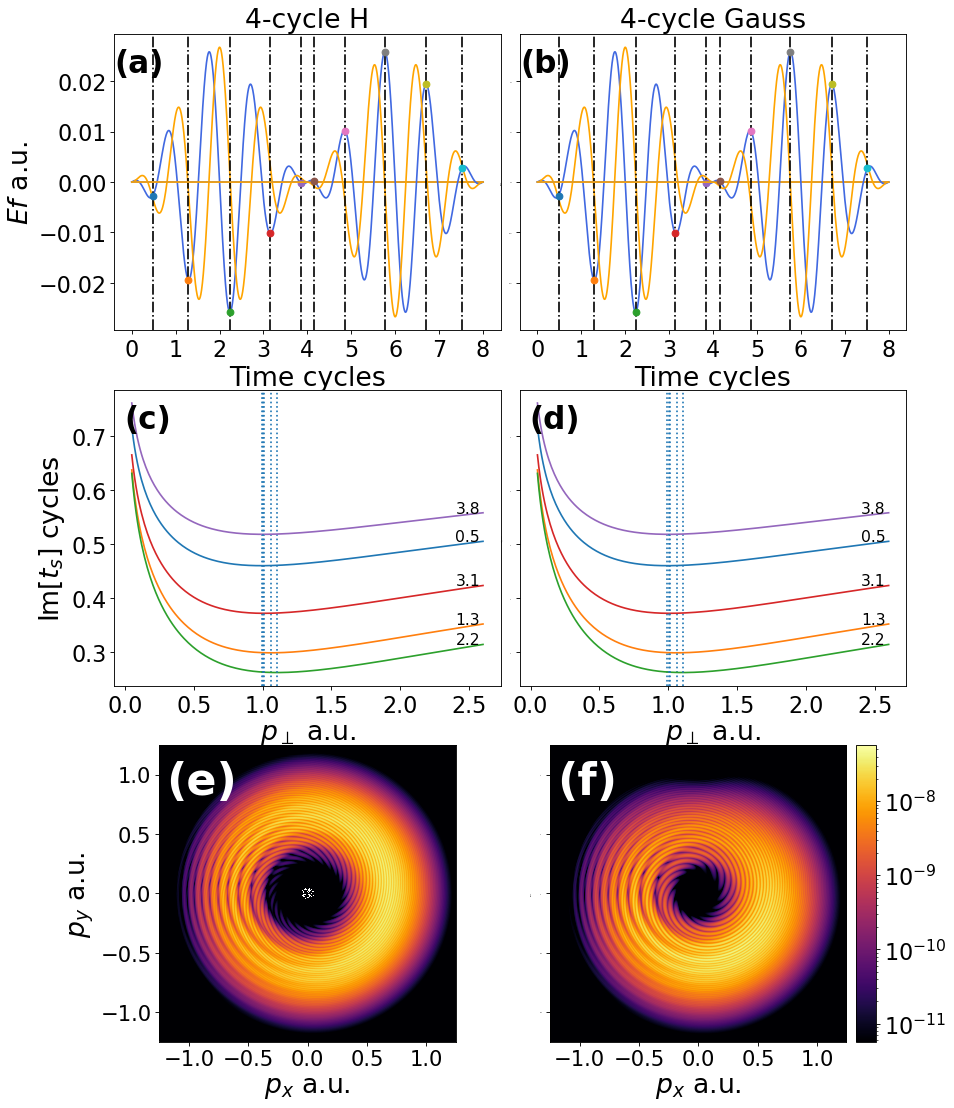

In [19]:
#[tSample, EfxList, EfyList, pList, tList,E1Pointsx,E1Pointsy,pIndx
#,MGrids, pxList, pyList, Mins] = loadDataDump('Times', DumpFileName)
plt.style.use('default')
dcolours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.tight_layout()
#plt.subplots_adjust(left=0.25, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.2)

panelLabels = np.array(['('+chr(i)+')' for i in range(ord('a'),ord('a')+Npulses*3)]).reshape(3, Npulses)
Titles = [str(NCycles)+'-cycle H', str(NCycles)+'-cycle Gauss']

plt.figure(num=None, figsize=(12, 14), dpi=80, facecolor='w', edgecolor='k')
plt.autoscale(tight=True)
# row 1 Efield
for i in range(0, Npulses):
    ax = plt.subplot(3, Npulses, i+1)
    ax.text(0.001, 0.95, panelLabels[0][i], transform=ax.transAxes,
      fontsize=28, fontweight='bold', va='top')
    plt.xlabel('Time cycles', fontsize=24)
    plt.ylabel('$Ef$ a.u.', fontsize= 24 if i==0 else 0)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20 if i==0 else 0)
    plt.gca().set_prop_cycle(None)
    plt.title(Titles[i],{'fontsize':24})
    for j in range(0, NFields):
        plt.plot(tSample* omegaIn/(2*Pi), EfxList[i][j], '-',label='Efx',color='royalblue')
        plt.plot(tSample* omegaIn/(2*Pi), EfyList[i][j], '-',label='Efy', color='orange')
    #plt.plot(tList[i][:,-1].real, E1Pointsx,'o')
        for k in range(0,len(tList[i][j])):
            plt.axvline(x=tList[i][j][k][pIndx].real* omegaIn/(2*Pi),color='black',linestyle='-.')
            plt.plot(tList[i][j][k][pIndx].real* omegaIn/(2*Pi), E1Pointsx[i][j][k],'o')
            #plt.plot(tList[i][j][k][pIndx].real* omegaIn/(2*Pi), E1Pointsy[i][j][k],'o')
#row 2 imaginary time plot   
#for i in range(0, 3):
    ax = plt.subplot(3, Npulses, Npulses+i+1)
    ax.text(0.025, 0.95, panelLabels[1][i], transform=ax.transAxes,
      fontsize=28, fontweight='bold', va='top')
    plt.ylabel('$\mathrm{Im}[{t_s}]$ cycles', fontsize=24 if i==0 else 0)
    plt.xlabel('$p_{\perp}$ a.u.', fontsize= 24 )
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20 if i==0 else 0)
    plt.gca().set_prop_cycle(None)
    #plt.ylim(0.15,0.7)
    
    for j in range(0, NFields-1):
        tLen = len(tList[i][j])
        for k in range(0,tLen):
            plt.plot(pList,np.array(tList[i][j][k]).imag * omegaIn/(2*Pi),'-')
            tend = tList[i][j][k][-1]* omegaIn/(2*Pi)
            plt.text(2.4, tend.imag, "{0:.1f}".format(tend.real),fontsize=(14))
            plt.axvline(x=Mins[i][j][k], color = dcolours[j],linestyle='dotted')
    plt.gca().set_prop_cycle(None)

#row 3 momentum distribusion
#for i in range(0, 3):
    ax = plt.subplot(3, Npulses, 2*Npulses+i+1)
    ax.text(0.025, 0.95, panelLabels[2][i], transform=ax.transAxes,
      fontsize=40, fontweight='bold', va='top', color ='white')
    plt.ylabel('$p_{y}$ a.u.', fontsize=(24 if i==0 else 0))
    plt.xlabel('$p_{x}$ a.u.', fontsize=(24))
    plt.xticks(fontsize=(19))
    plt.yticks(fontsize=(19 if i==0 else 0))
    
    #ax = plt.gca()
    M = np.abs(sum(MGrids[i]))**2
    Max = np.max(M)
    im = ax.imshow(np.flip(M,0), extent = (np.amin(pxList), np.amax(pxList), np.amin(pyList), np.amax(pyList)),
              cmap=cm.inferno, norm=LogNorm(vmin=Max*1e-4, vmax=Max), 
                interpolation = 'bicubic', aspect = 1.)

    if(i==Npulses-1):
        aspect = 15
        pad_fraction = 0.5
        divider = make_axes_locatable(ax)
        width = axes_size.AxesY(ax, aspect=1./aspect)
        pad = axes_size.Fraction(pad_fraction, width)
        cax = divider.append_axes("right", size=width, pad=pad)
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=20)

#plt.margins(0.1,0.1)
plt.subplots_adjust(top = 0.975, bottom = 0.075, right = 0.925, left = 0.1, hspace = 0.2, wspace = 0.05)
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("/home/au690496/Dropbox/Documents/2021_MarieCurie_Aarhus/attoSIM/Documents/Figures/AttoSim_"+str(NCycles)+"Cycle_Vortex.pdf")